In [1]:
import matplotlib.pyplot as plt
import datetime
import os
import numpy as np
import scipy
from scipy.integrate import simps

In [2]:
def parse_txt_args(filename):
    file_args = os.path.basename(filename).split('_')   # e.g. gpu_pwr_plain_T4_0_50_9.txt
    algo = file_args[2]
    device = file_args[3]
    size = file_args[6]
    separator = '.'
    size = size.split(separator, 1)[0]
    return algo, device, size

In [3]:
def get_pwr_elapsed_times(lines):
    pwr = []
    timestamps = []
    for i, line in enumerate(lines):
        if i == 0 or line.startswith('#') or line.startswith('COMPLETED'):
            continue
        vals = line.strip().split(',')
        timestamp_str = vals[0]
        y_val = float(vals[1])
        timestamp = datetime.datetime.strptime(timestamp_str, '%Y/%m/%d %H:%M:%S.%f')
        timestamps.append(timestamp)
        pwr.append(y_val)
    
    start_time = timestamps[0]
    elapsed_times = [(t - start_time).total_seconds()*1000 for t in timestamps]
    return pwr, elapsed_times

In [4]:
def compute_energy(pwr, elapsed_times):
    energy = simps(pwr, elapsed_times)/1000
    runtime = max(elapsed_times)/1000 - 6
    return energy, runtime

In [5]:
def get_power_baseline(pwr):
    sample = int(3000/50)   # average power of the first 3 seconds
    baseline = sum(pwr[0:sample])/(sample)
    return baseline

In [6]:
def normalize_power(baseline, pwr, elapsed_times):
    return compute_energy([p-baseline for p in pwr], elapsed_times)[0]

In [16]:
def orgranize_data(dir_name):
    directory = os.fsencode(dir_name)
    plain = dict()
    naive = dict()
    naive_A100 = dict()
    coalesced = dict()
    energy_runtime = dict()
    
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if filename.endswith('.txt'):
            algo, device, size = parse_txt_args(filename)
            with open('../data/'+filename, 'r') as f:
                lines = f.readlines()
                pwr, elapsed_times = get_pwr_elapsed_times(lines)
                energy, runtime = compute_energy(pwr, elapsed_times)
                baseline = get_power_baseline(pwr)
                normalized = normalize_power(baseline, pwr, elapsed_times)
                print('algo:%s, device:%s, size:%s, energy:%.2f, normalized:%.2f, baseline:%.2f, runtime:%.2f'
                      %(algo, device, size, energy, normalized, baseline, runtime))
                if device == 'A100':
                    naive_A100[size] = [pwr, elapsed_times]
                else:
                    k = algo+' '+size
                    energy_runtime[k] = (normalized, runtime)
                    if algo == 'plain':
                        plain[size] = [pwr, elapsed_times]
                    elif algo == 'naive':
                        naive[size] = [pwr, elapsed_times]
                    elif algo == 'coalesced':
                        coalesced[size] = [pwr, elapsed_times]
    return plain, naive, coalesced, naive_A100, energy_runtime

In [8]:
def pad(y, target_len):
    return y + (target_len-len(y))*[None]

In [9]:
def same_size_data(plain, naive, coalesced, s):
    pwrs = [plain[s][0], naive[s][0], coalesced[s][0]]
    elapsed_times = [plain[s][1], naive[s][1], coalesced[s][1]]
    max_p = max([len(p) for p in pwrs])
    max_e = 0
    times = None
    pwrs_padded = []
    for i, p in enumerate(pwrs):
        if len(p) < max_p:
            pwrs_padded.append((pad(p, max_p), i))
        else:
            pwrs_padded.append((p, i))
    for e in elapsed_times:
        if len(e) > max_e:
            max_e = len(e)
            times = e
    return pwrs_padded, times

In [10]:
def compare_same_size(naive, naive_A100, s):
    pwrs = [naive[s][0], naive_A100[s][0]]
    elapsed_times = [naive[s][1], naive_A100[s][1]]
    max_p = max([len(p) for p in pwrs])
    max_e = 0
    times = None
    pwrs_padded = []
    for i, p in enumerate(pwrs):
        if len(p) < max_p:
            pwrs_padded.append((pad(p, max_p), i))
        else:
            pwrs_padded.append((p, i))
    for e in elapsed_times:
        if len(e) > max_e:
            max_e = len(e)
            times = e
    return pwrs_padded, times

In [11]:
def gen_plot(pwrs, times, s, xtick, title):
    algo_i = {0:'plain', 1:'naive', 2:'coalesced'}
    size_i = {'9': '512x512', '10':'1024x1024', '11':'2048x2048'}
    
    fig = plt.figure(figsize=(10, 6))        
    x_ticks = range(int(min(times)), int(max(times))+1, xtick)
    plt.xticks(x_ticks)
    for i in range(len(pwrs)):
        plt.plot(times, pwrs[i][0], label=algo_i[pwrs[i][1]])
    plt.xlabel('Time (ms)')
    plt.ylabel('Power Consumption (W)')
    plt.title(title+size_i[s]+'')
    plt.legend()
    plt.show()

In [12]:
def compare_plot(pwrs, times, s, xtick, title):
    gpu_i = {0:'T4', 1:'A100'}
    size_i = {'9': '512x512', '10':'1024x1024', '11':'2048x2048'}
    
    fig = plt.figure(figsize=(10, 6))        
    x_ticks = range(int(min(times)), int(max(times))+1, xtick)
    plt.xticks(x_ticks)
    for i in range(len(pwrs)):
        plt.plot(times, pwrs[i][0], label=gpu_i[pwrs[i][1]])
    plt.xlabel('Time (ms)')
    plt.ylabel('Power Consumption (W)')
    plt.title(title+size_i[s]+'')
    plt.legend()
    plt.show()

In [28]:
def compare_gpu(naive, naive_A100):
    xticks = {'10':3000, '11':30000}
    title = 'Matrix Multiplication with Naive Parallelism on Different GPUs - Matrix dimension: '
    for s, xtick in xticks.items():
        pwrs, times = compare_same_size(naive, naive_A100, s)
        compare_plot(pwrs, times, s, xtick, title)

In [29]:
def get_gradient(x, y):
    return np.polyfit(x, y, 1)

In [97]:
def plot_energy_runtime(energy_runtime):
    plain_x = []
    plain_y = []
    naive_x = []
    naive_y = []
    coalesced_x = []
    coalesced_y = []
    for k, v in energy_runtime.items():
        x = k.split(' ')
        algo = x[0]
        size = x[1]
        energy, runtime = v
        if algo == 'plain':
            plain_x.append(runtime)
            plain_y.append(energy)
        elif algo == 'naive':
            naive_x.append(runtime)
            naive_y.append(energy)
        elif algo == 'coalesced':
            coalesced_x.append(runtime)
            coalesced_y.append(energy)
    
    plain_z = np.polyfit(plain_x, plain_y, 3)
    plain_f = np.poly1d(plain_z)
    plain_y_new = plain_f(plain_x)
    naive_z = np.polyfit(naive_x, naive_y, 3)
    naive_f = np.poly1d(naive_z)
    naive_y_new = naive_f(naive_x)
    coalesced_z = np.polyfit(coalesced_x, coalesced_y, 3)
    coalesced_f = np.poly1d(coalesced_z)
    coalesced_y_new = coalesced_f(coalesced_x)
    fig = plt.figure(figsize=(10, 6))  
    plt.plot(plain_x,plain_y, 'ro',plain_x, plain_y_new,label='plain', ms=10, alpha=0.3,c='r')
    plt.plot(naive_x,naive_y,'b^',naive_x, naive_y_new, label='naive', ms=20, alpha=1,c='b')
    plt.plot(coalesced_x,coalesced_y,'g*', coalesced_x, coalesced_y_new, label='coalesced', ms=25, alpha=0.7,c='g')
    plt.xlim(-10, 200)
    plt.ylim(-1000, 10000)
    plt.xlabel('Time (s)')
    plt.ylabel('Energy Consumption (J)')
    plt.title('Energy Consumption Comparison')
    plt.legend()
    plt.show()

algo:naive, device:T4, size:10, energy:465.21, normalized:262.45, baseline:10.33, runtime:13.63
algo:plain, device:T4, size:10, energy:7574.03, normalized:5651.92, baseline:10.45, runtime:177.89
algo:plain, device:T4, size:11, energy:70172.78, normalized:51565.83, baseline:11.95, runtime:1550.91
algo:naive, device:T4, size:11, energy:4373.62, normalized:2783.66, baseline:10.37, runtime:147.33
algo:naive, device:T4, size:9, energy:135.88, normalized:56.29, baseline:10.67, runtime:1.46
algo:naive, device:A100, size:10, energy:647.61, normalized:50.67, baseline:36.28, runtime:10.45
algo:coalesced, device:T4, size:9, energy:129.15, normalized:36.22, baseline:12.53, runtime:1.42
algo:plain, device:T4, size:9, energy:921.61, normalized:628.22, baseline:10.53, runtime:21.87
algo:coalesced, device:T4, size:10, energy:498.77, normalized:253.91, baseline:12.31, runtime:13.89
algo:naive, device:A100, size:11, energy:3825.83, normalized:238.40, baseline:36.69, runtime:91.79
algo:coalesced, device:

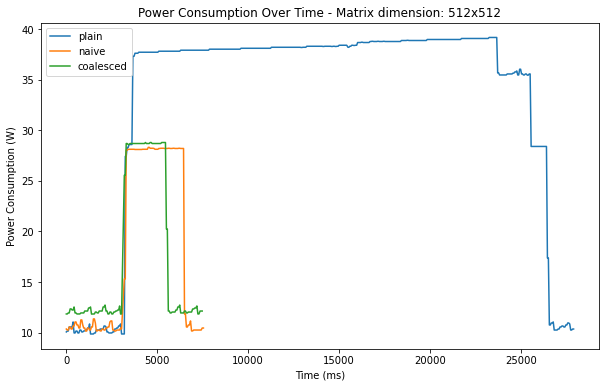

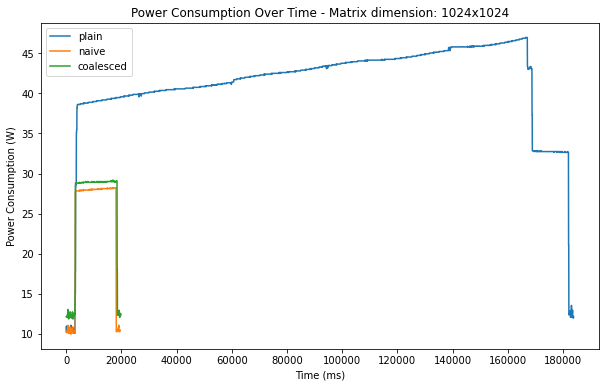

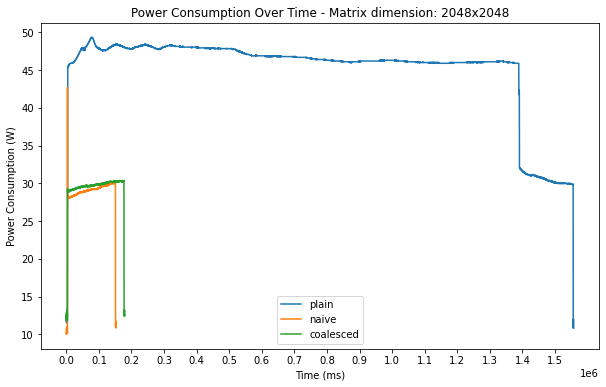

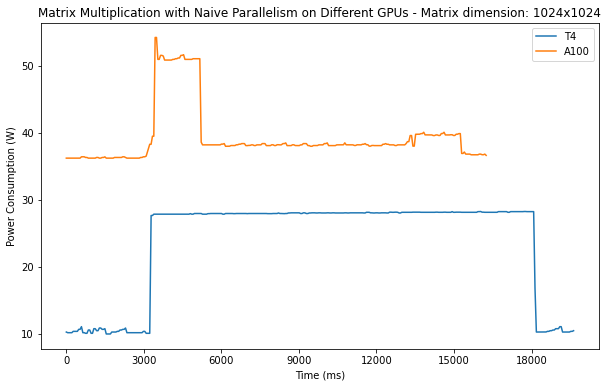

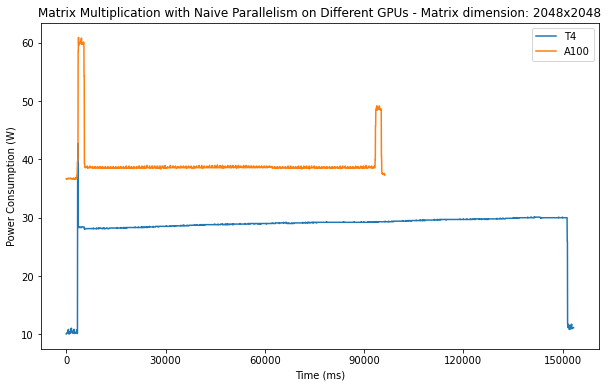

/var/folders/jw/zkystpkx2jz0jl0lkn5d5gn80000gn/T/ipykernel_5470/2137119145.py:9: RankWarning: Polyfit may be poorly conditioned
  plot_energy_runtime(energy_runtime)
/var/folders/jw/zkystpkx2jz0jl0lkn5d5gn80000gn/T/ipykernel_5470/2137119145.py:9: RankWarning: Polyfit may be poorly conditioned
  plot_energy_runtime(energy_runtime)
/var/folders/jw/zkystpkx2jz0jl0lkn5d5gn80000gn/T/ipykernel_5470/2137119145.py:9: RankWarning: Polyfit may be poorly conditioned
  plot_energy_runtime(energy_runtime)
/var/folders/jw/zkystpkx2jz0jl0lkn5d5gn80000gn/T/ipykernel_5470/584940020.py:33: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(plain_x,plain_y, 'ro',plain_x, plain_y_new,label='plain', ms=10, alpha=0.3,c='r')
/var/folders/jw/zkystpkx2jz0jl0lkn5d5gn80000gn/T/ipykernel_5470/584940020.py:34: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt stri

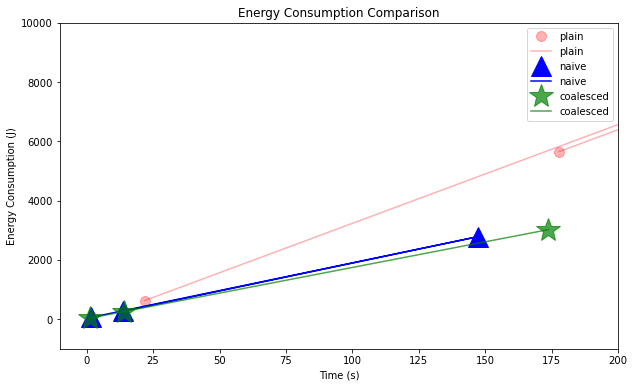

In [98]:
def plot_pwr():
    dir_name = '../data/'
    xticks = {'9':5000, '10':20000, '11':100000}
    plain, naive, coalesced, naive_A100, energy_runtime = orgranize_data(dir_name)
    for s, xtick in xticks.items():
        pwrs, times = same_size_data(plain, naive, coalesced, s)
        gen_plot(pwrs, times, s, xtick, 'Power Consumption Over Time - Matrix dimension: ')
    compare_gpu(naive, naive_A100)
    plot_energy_runtime(energy_runtime)
plot_pwr()